# Imports, setup

In [46]:
import nextgenfilter as ngf
import nextgenanalyze as nga
import ngsCSVAnalyze as csva

import yaml
import cPickle as pickle
import sys, os

import pandas as pd

import time
import progressbar

import matplotlib.pyplot as plt

%matplotlib inline

# Load YAML file, set up things

In [35]:
folder = r"C:\Users\Ted\Google Drive\To File - Research Docs\Screening\nextgenAnalysis\Data\2015_12_01_AMD"
yfname = folder+'\\'+'samples_short.yaml'

with open(yfname) as expt_f:
    expt_yaml = yaml.load(expt_f)
    
runs = expt_yaml['ngsruns']

### Define a trial run
Just change "run" to whatever run you want to look at, I guess.

In [36]:
run = 'run1'
expts = runs[run]['experiments']

bcs = {}
templates = {}
for expt in expts:
    bcs[expt] = expt_yaml['experiments'][expt]['barcode']
    templates[expt] = expt_yaml['experiments'][expt]['template_seq']

# Filter

### Define inputs, do some setup

In [37]:
fName = folder+'\\'+runs[run]['f_read_name']
peName = folder+'\\'+runs[run]['pe_read_name']
f_filt_seqs = runs[run]['filter_seqs']['forward']
r_filt_seqs = runs[run]['filter_seqs']['reverse']

fREs = ngf.compileREs(f_filt_seqs)
peREs = ngf.compileREs(r_filt_seqs)

In [42]:
fSeqs = list(ngf.loadNGSFileToIterator(fName))
for regex in fREs:
    fSeqs = ngf.filterSeqs(fSeqs, regex)
peSeqs = list(ngf.loadNGSFileToIterator(peName))
for regex in peREs:
    peSeqs = ngf.filterSeqs(peSeqs, regex)
    
bcSeqs = ngf.barcodeDemux(fSeqs, bcs)

peFiltSeqs = ngf.filterPEMismatches(bcSeqs[expts[0]], peSeqs, ngf.copiedFunctionGenerator(fREs))

In [45]:
print len(list(ngf.loadNGSFileToIterator(fName)))
print len(fSeqs)
print len(peSeqs)
print len(bcSeqs[expts[0]])
print len(peFiltSeqs)

4547
3978
4547
3978
3759


### Do fancier filtering

In [51]:
reload(ngf)

<module 'nextgenfilter' from 'C:\Users\Ted\Google Drive\To File - Research Docs\Screening\nextgenAnalysis\nextgen4B\nextgenfilter.py'>

In [54]:
shortSeqs = ngf.seqLenFilter(peFiltSeqs, l_cutoff=20, u_cutoff=60, l_barcode=len(bcs[expt]))
longSeqs = ngf.seqLenFilter(peFiltSeqs, l_barcode=len(bcs[expt]))

In [55]:
print len(shortSeqs)
print len(longSeqs)

502
2951


In [63]:
print [str(s.seq) for s in shortSeqs]

['TCTCCGCTTCTTAACCAAGTCTCTGCTACCGTAA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGTTTGCTGA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCA', 'TCTCCGCTTCTTTCCTTTCCA', 'TCTCCGCTTCTTTCCTTTCCTTTCCAA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTATCCTTTTTGTTTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGTTTGCTGTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGTTTGCTGTTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGA', 'TCTCCGCTTCTTTCCTTTCCTTTCA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGTTTGCTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGTA', 'TGTGTTTTGGGTGTTCTCCA', 'TCTCCGCTTCTTTCCTTTCCA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTA', 'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGA', 'TCTCCGCTTCTTTCCTTTCCTTTCCAT

In [61]:
str(longSeqs[2].seq)

'TCTCCGCTTCTTTCCTTTCCTTTCCATGCTTCTTCTCTCTCCTTTTTGTTTGCTGTTTGGTGTTGTTTTGGGTGTTCTCA'

In [64]:
shortQSeqs = ngf.qualityFilter(shortSeqs)

### Reimplement alignfilter
Want to see distributions of alignment scores, etc.

In [70]:
import os
import logging
import uuid

from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Emboss.Applications import NeedleCommandline

gapopen=10
gapextend=0.5
lo_cutoff=300
hi_cutoff=1000

In [81]:
start_nSeqs = len(shortQSeqs)

# Save the template and sequences as temporary fasta files
# Probably some hacking that can be done in the NeedleCommandline stuff
# But for now, this is easiest.
template_fname = 'temptemplate.fa'
seqs_fname = 'tempseq.fa'
template = templates[expt]

with open(seqs_fname, 'w') as sh:
    SeqIO.write(shortQSeqs, sh, 'fastq')

with open(template_fname, 'w') as tem:
    tempSeq = SeqRecord(Seq(template), id='template', name='template')
    SeqIO.write(tempSeq, tem, 'fasta')

# Generate alignment command, run the alignment
logging.info('Began EMBOSS needle routine')
ofilen = 'temp_'+str(uuid.uuid4())+'.needle'
needle_cline = NeedleCommandline(asequence=template_fname, bsequence=seqs_fname, gapopen=gapopen,
    gapextend=gapextend, outfile=ofilen)
needle_cline()
logging.info('Finished EMBOSS needle routine')

# Read in alignment file
# **NOTE: This code assumes you've edited EmbossIO to keep track of the score
# and keep it as an annotation of the MultipleSeqAlign object

alnData = AlignIO.parse(open(ofilen), "emboss")

In [82]:
foo = list(alnData)

In [83]:
annots = [x.annotations for x in foo]
scores = [a['score'] for a in annots]

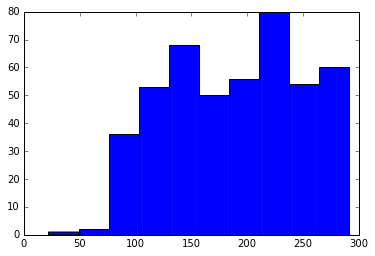

In [85]:
plt.figure()
plt.hist(scores)
plt.show()